### Librerias Usadas.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA, KernelPCA
from gensim.parsing.preprocessing import remove_stopwords
from gensim.models import Word2Vec
from scipy.sparse import csr_matrix, hstack
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import tensorflow as tf
import re, string, nltk
from wordcloud import WordCloud

# Descarga de recursos
nltk.download('wordnet')
nltk.download('punkt')
tf.test.gpu_device_name()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


''

## Lectura de los datos

In [4]:
COLAB = False
if COLAB:
    from google.colab import drive

    drive.mount("/content/drive")
    dataFake = pd.read_csv("/content/drive/MyDrive/Fake.csv")
    dataTrue = pd.read_csv("/content/drive/MyDrive/True.csv")
else:
    dataFake = pd.read_csv("Fake.csv")
    dataTrue = pd.read_csv("True.csv")

Mounted at /content/drive


In [5]:
dataFake["class"] = 0
print("Fake: ",dataFake.shape)

dataTrue["class"] = 1
print("True: ",dataTrue.shape)

data_merge = pd.concat([dataFake,dataTrue], axis=0)
data = data_merge.drop(["title","subject","date"], axis=1)
print("All data: ",data.shape)

Fake:  (23481, 5)
True:  (21417, 5)
All data:  (44898, 2)


## Limpieza

Se trató a los datos de esta entrega de la misma manera que los de la entrega principal, con el fin de mantener la congruencia.

In [6]:
def word_cleaner(text):
  '''Función que elimina los símbolos especiales de un texto,
  así como las stopwords
  '''
  text = text.lower()
  text = re.sub('\[.*?\]', '', text)
  text = re.sub('\\W', ' ', text)
  text = re.sub('https?://\S+|www\.\S+', '', text)
  text = re.sub('<.*?>+', '', text)
  text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
  text = re.sub('\n', '', text)
  text = re.sub('\w*\d\w*', '', text)
  return remove_stopwords(text)

def text_cleaner(text, lemmatizer):
  '''Función que dado un texto, lo limpia y elimina las letras aisladas existentes.
  '''
  text = word_cleaner(text)
  tokens = word_tokenize(text)
  lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
  text = remove_letters(lemmatized_tokens)
  text = " ".join(text)
  return text


def remove_letters(lemas, length=2):
  '''Funcion que elimina las palabras con lengitud menor a length
  '''
  return [word for word in lemas if len(word)>length]


def count_tokens(texts, wf):
  ''' Funcion que cuenta la frecuencia de palabras en el dataset
  '''
  for text in texts:
    tokens = text.split()
    wf.update(tokens)
  return wf


def remove_max_min_words_freq(texts, words_to_remove):
  ''' Funcion que dado el dataset y la lista de palabras que no tienen una 
  frecuencua valida las elimina del dataset
  '''
  filtered_texts = []
  for text in texts:
    tokens = text.split()
    filtered_tokens = [word for word in tokens if word not in words_to_remove]
    filtered_text = ' '.join(filtered_tokens)
    filtered_texts.append(filtered_text)
  return filtered_texts


def get_words_to_remove(min_freq =2, max_freq=1000, word_freq=None):
  ''' Funcion que obtiene la lista de palabras a eliminar
  '''
  return [word for word, freq in word_freq.items() if freq < min_freq or freq > max_freq]

### Aplicación de limpieza a datos

Separamos los datos en noticias falsas y verdaderas, tambien se aplicaron las funciones de lematización y tokenización



In [7]:
clean_fake = dataFake.copy()
lemmatizer = WordNetLemmatizer()
clean_fake['text'] = clean_fake['text'].apply(text_cleaner, args=(lemmatizer,))

In [8]:
clean_true = dataTrue.copy()
lemmatizer = WordNetLemmatizer()
clean_true['text'] = clean_true['text'].apply(text_cleaner, args=(lemmatizer,))

## Separación de datos de entrenamiento y de prueba

Ahora se separa cada tipo de dato en sus respectivos sets de entrenamiento y prueba

In [9]:
SEED = 123456789

x_true = clean_true['text']
y_true = clean_true['class']

x_train_true, x_test_true, y_train_true, y_test_true = train_test_split(x_true, y_true, test_size=0.25, random_state=SEED)

print(f"Datos de entrenamiento: {len(x_train_true)} ({len(x_train_true)/len(x_true):%})")
print(f"Datos de prueba: \t{len(x_test_true)} ({len(x_test_true)/len(x_true):%})")

Datos de entrenamiento: 16062 (74.996498%)
Datos de prueba: 	5355 (25.003502%)


In [10]:
x_fake = clean_fake['text']
y_fake = clean_fake['class']

x_train_fake, x_test_fake, y_train_fake, y_test_fake = train_test_split(x_fake, y_fake, test_size=0.25, random_state=SEED)

print(f"Datos de entrenamiento: {len(x_train_fake)} ({len(x_train_fake)/len(x_fake):%})")
print(f"Datos de prueba: \t{len(x_test_fake)} ({len(x_test_fake)/len(x_fake):%})")

Datos de entrenamiento: 17610 (74.996806%)
Datos de prueba: 	5871 (25.003194%)


## Word2Vec

A partir de este punto se trabaja con Word2Vec para vectorizar las palabras más frecuentes de cada tipo de datos (noticias falsas/verdaderas).

El fin de llevar a cabo este proceso es mostrar la forma en que se agrupan los vectores de palabras y deducir si esto tiene relación con la forma en la que LR y KNN clasificaron las noticias de los datos completos.

In [11]:
# Entrenamos el modelo para los datos verdaderos
X = pd.concat([x_train_true, x_test_true], axis=0)
sentences = [text.split() for text in X]
word2vec_model = Word2Vec(sentences, min_count=2)

In [12]:
# Entrenamos el modelo para los datos falsos
X_fake = pd.concat([x_train_fake, x_test_fake], axis=0)
sentences_fake = [text.split() for text in X_fake]
word2vec_model_f = Word2Vec(sentences_fake, min_count=2)

Usando la función `most_similar`, buscamos para cada modelo las palabras relacionadas a una de las que más repeticiones tuvieron (tanto en las noticias falsas como las verdaderas)



In [12]:
word2vec_model.wv.most_similar('trump')

[('elect', 0.6491174697875977),
 ('washington', 0.485962450504303),
 ('obama', 0.48377183079719543),
 ('bush', 0.4748460054397583),
 ('republican', 0.4728362262248993),
 ('surprise', 0.4660532474517822),
 ('clinton', 0.46550247073173523),
 ('incoming', 0.45599403977394104),
 ('presumptive', 0.45119884610176086),
 ('cruz', 0.4486404061317444)]

In [13]:
word2vec_model_f.wv.most_similar('trump')

[('elect', 0.6708611845970154),
 ('actually', 0.5508329272270203),
 ('hasn', 0.5336906909942627),
 ('amateur', 0.5105623006820679),
 ('conway', 0.501033365726471),
 ('repeatedly', 0.49410584568977356),
 ('pathetic', 0.4832920730113983),
 ('embarrassing', 0.47700735926628113),
 ('brag', 0.4723009467124939),
 ('instead', 0.47010910511016846)]

In [14]:
list(zip(*word2vec_model_f.wv.most_similar('trump')))[0]

('elect',
 'actually',
 'hasn',
 'amateur',
 'conway',
 'repeatedly',
 'pathetic',
 'embarrassing',
 'brag',
 'instead')

Ahora, apoyados de los resultados obtenidos en la investigación de `CountVectorizer`, se obtendrán las palabras relacionadas para cada una de las que más aparecieron en cada tipo de noticias.

In [12]:
fake_keywords = [
    'medium', 'donald', 'black', 'video',
    'woman', 'com', 'featured', 'news', 
    'america', 'twitter', 'obama', 'time',
    'know', 'clinton', 'american', 'people',
    'hillary', 'like', 'image', 'trump'
]

true_keywords = [
    'said', 'reuters', 'state', 'government',
    'minister', 'official', 'united', 'china',
    'north', 'washington', 'party', 'republican',
    'leader', 'korea', 'tax', 'wednesday', 
    'house', 'tuesday', 'percent', 'senate',
]

In [88]:
# Inicializamos unos diccionarios auxiliares para guardar las palabras relacionadas por 
# cada keyword
fake = dict()
true = dict()

# Creamos una paleta con tantod colores como keywords tenemos
colores = [
    "#F6977A",
    "#FCC9B9",
    "#F9A17F",
    "#F98A60",
    "#E76F4C",
    "#EBA08C",
    "#FFB3A6",
    "#FF8C70",
    "#FF725C",
    "#FF5335",
    "#FCA69E",
    "#FC7B7B",
    "#FF5733",
    "#FF8759",
    "#FFA878",
    "#FFC4A3",
    "#FFDAB7",
    "#FFE3C2",
    "#FFEFDB",
    "#FFF8F4"
]


# Recuperamos unas palabras 'negativas' del set de falsas
bad_keywords = [
  'unpopular',
  'pathetic',
  'slugfest',
  'humiliating',
  'illegitimate',
]


# Recuperamos unas palabras 'neutras' del set de verdaderas
good_keywords = [
  'acknowledged',
  'described',
  'authority',
  'extending',
  'autonomy',
  'diplomat',
  'aide',
]

Comenzamos con la vectorización de las palabras relevantes

In [93]:
# Creamos un PCA de dos componentes para la reduccion de dimensiones de los vectores
pca = PCA(n_components=2)

# Creamos un KPCA de dos componentes 
kpca = KernelPCA(n_components=2, kernel='poly')

# Obtenemos los vectores para las keywords
vectors_false = [word2vec_model_f.wv[word] for word in fake_keywords] # falsas
vectors_true  = [word2vec_model.wv[word] for word in true_keywords]   # verdaderas

# Vectores de las plabras extraidas 
vectors_bad  = [word2vec_model_f.wv[word] for word in bad_keywords] # 'malas'
vectors_good = [word2vec_model.wv[word] for word in good_keywords]  # 'neutras'

# Reducción de dimensionalidad utilizando KPCA para los vectores de noticias verdaderas
vectors_true_pca = kpca.fit_transform(vectors_true)

# Reducción de dimensionalidad utilizando PCA para los vectores palabras 'neutras'
vectors_good_pca = pca.fit_transform(vectors_good)

# Reducción de dimensionalidad utilizando PCA
vectors_false_pca = pca.fit_transform(vectors_false) # Vectores de noticias falsas
vectors_bad_pca = pca.fit_transform(vectors_bad)     # Vectores de palabras 'malas'

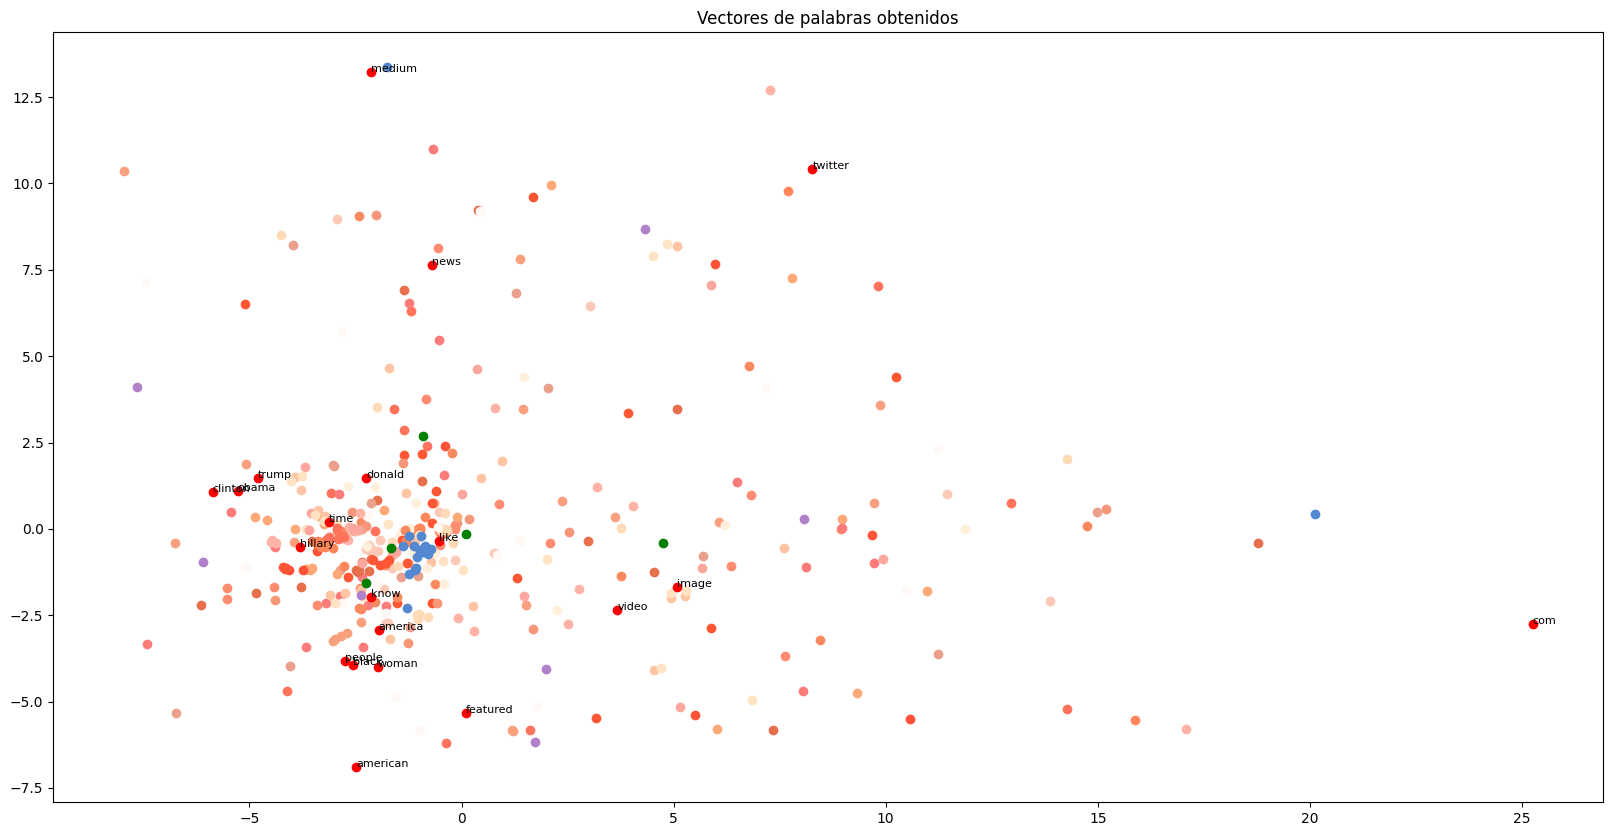

In [94]:
# Definimos el tamanio del grafico
plt.figure(figsize=(20, 10))

# Graficar los vectores para las noticias falsas
color_index = 0
for keyword in fake_keywords:
  fake[keyword] =  list(zip(*word2vec_model_f.wv.most_similar(keyword)))[0]
  #print(word, list(zip(*word2vec_model_f.wv.most_similar(word)))[0])
  
  related_words = list(zip(*word2vec_model_f.wv.most_similar(keyword)))[0]
  vectors = [word2vec_model_f.wv[word] for word in related_words]
  vectors_pca = pca.fit_transform(vectors) # Reduccion de dimensiones
  
  plt.scatter(vectors_pca[:, 0], vectors_pca[:, 1], color=colores[color_index])
  color_index += 1


# Graficar los vectores para las noticias verdaderas
index = 0
for keyword in true_keywords:
  true[keyword] =  list(zip(*word2vec_model.wv.most_similar(keyword)))[0]
  
  vectors = [word2vec_model.wv[word] for word in list(zip(*word2vec_model.wv.most_similar(keyword)))[0]]
  vectors_pca = pca.fit_transform(vectors) # Reduccion de dimensiones
  
  plt.scatter(vectors_pca[:, 0], vectors_pca[:, 1], color=colores[index])
  index += 1


# Agregamos al grafico los vectores obtenidos anteriormente tras aplicarles reduccion dimensional
plt.scatter(vectors_true_pca[:, 0], vectors_true_pca[:, 1], color="#5488D0") # Keywords de noticias verdaderas
plt.scatter(vectors_good_pca[:, 0], vectors_good_pca[:, 1], color="#B081C8") # Palabras extraidas 'neutras'

plt.scatter(vectors_false_pca[:, 0], vectors_false_pca[:, 1], color='red')   # Keywords de noticias falsas
plt.scatter(vectors_bad_pca[:, 0], vectors_bad_pca[:, 1], color='green')     # Palabras extraidas 'malas'

# Agregar etiquetas a los puntos de las keywords de noticias flasas
for i, word in enumerate(fake_keywords):
  plt.annotate(word, (vectors_false_pca[i, 0], vectors_false_pca[i, 1]), fontsize=8)


# Mostramos el grafico
plt.title('Vectores de palabras obtenidos')
plt.show()

In [ ]:
true

In [ ]:
fake

En general podemos apreciar que las noticias verdaderas usan palabras que mantienen un contexto más objetivo respecto a las falsas.

## Word clouds

Se consideró oportuno encontrar una manera llamativa de presentar el conjunto de palabras obtenidas.

In [13]:
def generate_word_cloud(word_list):

    # Convert the list of words into a string
    text = ' '.join(word_list)

    # Create the word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

    # Display the word cloud using matplotlib
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()
    
def generate_pie_chart(data, title):
    labels, porcentages = [], []
    
    for label, p in data:
        labels.append(label)
        porcentages.append(p)
        
    plt.pie(porcentages, labels=labels, autopct='%1.1f%%')
    plt.axis('equal')  
    plt.title(title)
    plt.show()

### 25 palabras más comunes en True.csv

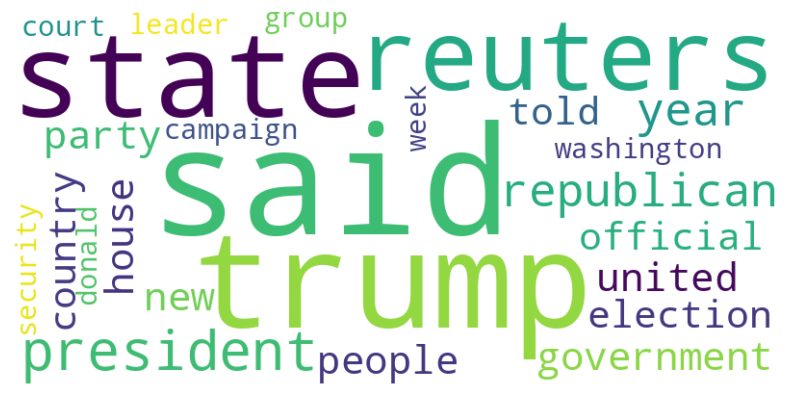

In [14]:
generate_word_cloud(word2vec_model.wv.index_to_key[:25])

### 25 palabras más comunes en Fake.csv

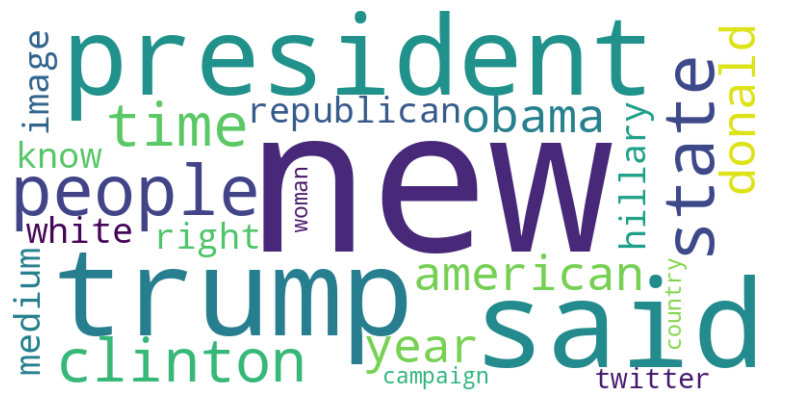

In [15]:
generate_word_cloud(word2vec_model_f.wv.index_to_key[:25])

## Pie charts

Del mismo modo, mostrar una porción de los datos como gráficos circulares. En ambos casos, para las palabrassrelacionadas a 'trump'.

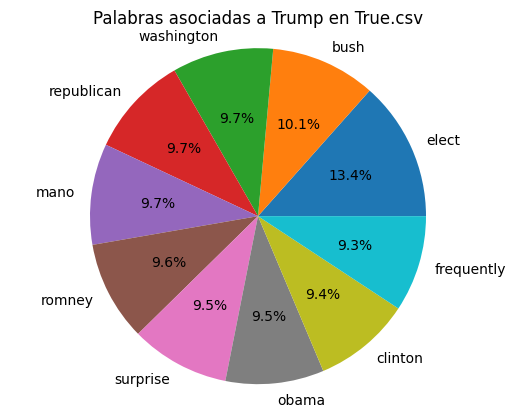

In [16]:
true_trump_words = word2vec_model.wv.most_similar('trump')
generate_pie_chart(true_trump_words, "Palabras asociadas a Trump en True.csv")

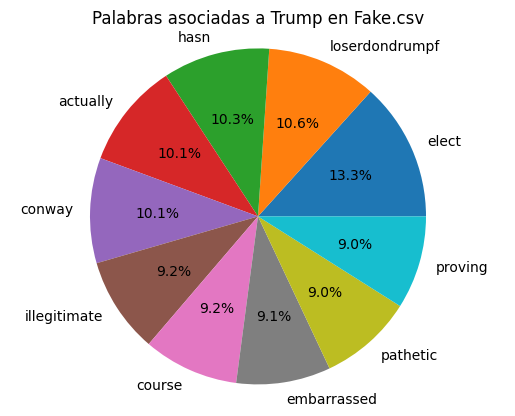

In [17]:
fake_trump_words = word2vec_model_f.wv.most_similar('trump')
generate_pie_chart(fake_trump_words, "Palabras asociadas a Trump en Fake.csv")